# Chapter 3, Classification
We will work with MNIST dataset for classifying handwritten digits with the corresponding actual value. Scikit provides handy functions to get this dataset.

#### Warning!
The book uses a different method to download MNIST dataset but it seems it is not working, hence I'm using the official sickit's method to download mnist.

In [1]:
from sklearn.datasets import fetch_openml

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def print_samples(X, y, shape = (2, 2), raw=False, print_labels=True):
    """Print n random samples"""
    if raw:
        rand_indx = np.random.randint(0, len(X), shape[0])
        samples = zip(X[rand_indx], y[rand_indx])
        print(list(samples))
    else:
        n_samples = int(shape[0]) * int(shape[1])
        rand_indx = np.random.randint(0, len(X), n_samples)
        samples = zip(X[rand_indx], y[rand_indx])
        idx = 1
        for features, label in samples:
            # X is a flattened array, to print the image we need
            # to reshape it into a 28 x 28 figure
            plt.subplot(*shape, idx)
            plt.tight_layout()
            plt.imshow(features.reshape(28,28), cmap=plt.cm.gray_r)
            if print_labels:
                plt.title("Label: {}".format(label))
            idx+=1
        plt.show()

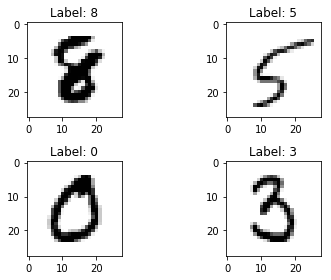

In [3]:
print_samples(X, y, (2, 2))

#### Remember!
Always create the training, validation and test set.

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Warning
You have to keep in mind the data you are dealing with and the possible algorithms and validation methods you are going to use. Some algorithms are sensitive to the order of the training set hence we don't want to feed them in the same order every time.

Also, if we are going to use k-fold cross-validation, we want to ensure that every fold get's samples of every number.

In [5]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a binary classifier
Say we want to just be able to detect if a particular sample is a 5 or not, this is an example of a binary classifier i.e., true or false.

### Warning
The way we loaded MNIST, the labels are strings not ints, hence we test with the string '5' as opposed to the int 5

In [6]:
# This simply will change the labels to True, the number is a 5, and False, is not
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

### Stochastic Gradient Descent
This algorithm handles large datasets efficiently and works on training instances independently, i.e., one at a time.

We'll use sickit's ```SGDClassifier```

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
# This means the first digit was predicted to be a five
sgd_clf.predict(X_train[10:20])

array([False, False, False, False, False,  True, False, False, False,
        True])

Now let's measure the model's performance with K-fold cross validation

In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been add

array([0.9385 , 0.96535, 0.9685 ])

90-95% of accuracy!, very impressive, before continuing, let's see what happens when we create a model exclusively for not-5 class.

In [10]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.912  , 0.90765, 0.9093 ])

Wow!, almost the same score, it seems our model is not that good after all. This is because of all the samples, only 10% of them are actually 5. So a model that predicts 90% of the time the image is not a 5 given this circumstances, it is not that useful.

This is a hint to say that 'accuracy' is not always the best metric for classifiers, especialluy when dealing with skewed datasets.

## Confusion Matrix

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been add

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53203,  1376],
       [ 1177,  4244]])

Each row of the confusion matrix represents the actual classes while each column represents the predicted values, where they cross is the correct classified categories, for instance, the first row represents non-5 and the first column represents predicted non-5, so, we could interpret as: Of all real non-5's we correctly predicted 53988.

The second column represents actual 5's, so we could read: Of all real non-5's we wrongly classified 591 as 5's.

## Concise metrics
The matrix alone is useful but we might need to calculate more concise metrics to have a better representation or "score" for the data. for instance:

### Precision
"Of all true positives and false positives, how much my model was able to hit", this metric tries to evaluate the predictions against the reality, think of it as a "row" metric.
$$
precision=\frac{TP}{TP + FP}
$$
### Recall
"Of all true positives and false negatives, how much mu model was able to hit", this metrics tries to evaluate how sensitive the predictions are, say, how much varies the predictions for a specific class, think of it as a "column" metric
$$
recall = \frac{TP}{TP + FN}
$$

In [13]:
from sklearn.metrics import precision_score, recall_score

ps = precision_score(y_train_5, y_train_pred)
rs = recall_score(y_train_5, y_train_pred)

print("Precision: ", ps)
print("Recall: ", rs)

Precision:  0.7551601423487544
Recall:  0.782881387197934


Now the model does not look as good as before, this means it was only to correctly predict 86% of the 5s, and it was only able to detect 71% of the 5s.

### F1 score - harmonic mean of precision and recall
It is often convinient to combien both precision and recall into a single metric called $F_1 score$. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.

$$
F_1 =\frac{2}{\frac{1}{precision}+\frac{1}{recall}} = 2\times \frac{precision\times recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$

In [14]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7687709446608098

#### Precision & recall trade-off
You can't both socores high, you can increase the precision but at the same time you recall might get down and the same in opposite direction. For SGD classifier, there is a threshold for classification where the model decides if the instance is in one side or the other. If we increase the threshold, we might increase the precision, but at the same time leave other 5 instances out which translates to a lower recall. In the same sense, if we lower the threshold, we increase the recall, i.e., the model is able to detect more of them, but lower the precission by letting pass non-5 instances.

We can't mess around with the threshold value on Scikit's SGDClassifier directly, but we can try an alternative.

In [15]:
y_scores = sgd_clf.decision_function(X_train[0:1])
y_scores

array([-178910.74617153])

In [16]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print("Is a 5? ", y_some_digit_pred)
print("It was really a 5?", y_train_5[0])

Is a 5?  [False]
It was really a 5? False


With threshold 0, the default in ```SGDClassifier```, the specific instance shown above, predicts a 5. Now let's try with a different threshold.

In [17]:
threshold = 300000
y_some_digit_pred = (y_scores > threshold)
print("Is a 5? ", y_some_digit_pred)
print("It was really a 5?", y_train_5[0])

Is a 5?  [False]
It was really a 5? False


Since we can't control the threshold used by the algorithm, we will first need to get every instance individual score and play around with the values and a different threshold.

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been add

In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

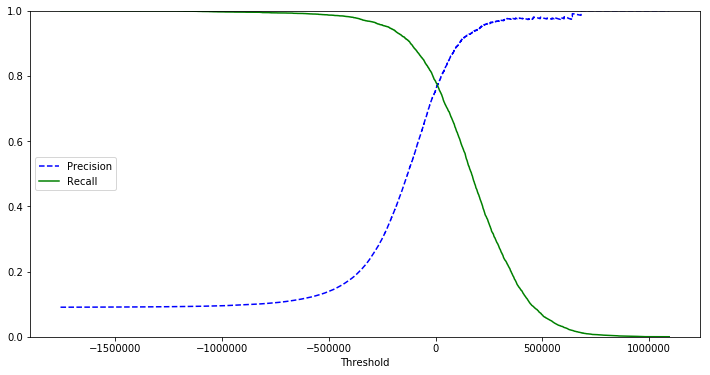

In [20]:
import matplotlib.pyplot as plt

def plot_recision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12,6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    plt.show()
    
plot_recision_recall_vs_threshold(precisions, recalls, thresholds)

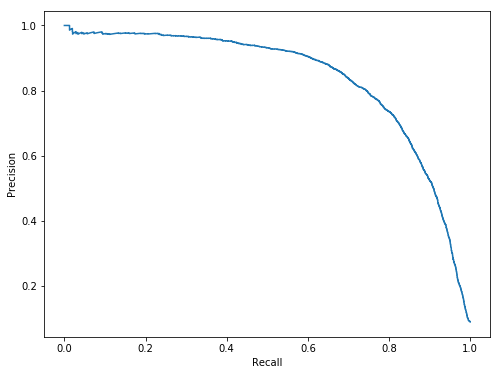

In [21]:
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

Depending on the project, you will need to decide the trade-off, from the plot above, you can observe the precision drops sharply around 80% of recall, so one option would be to aim for a 60% of recall.

For instance, say you want to aim for 90% of precision, according to the Recall VS Precision plot, you might want to try a threshold of 70000 for that.

In [22]:
y_train_pred_90 = (y_scores > 70000)
ps = precision_score(y_train_5, y_train_pred_90)
rs = recall_score(y_train_5, y_train_pred_90)
print("Precision score: ", ps)
print("Recall score: ", rs)

Precision score:  0.8585434173669467
Recall score:  0.6784726065301605


### The receiver operating characteristic (ROC) curve
This is a common tool for binary classifiers. It's similar to precision vs recall curve, but compares *true positive rate* (another name for recall) and *false positive rate*. The FPR is the ratio of negative instances that are incorreclty classified as positive.

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12, 6))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0,1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

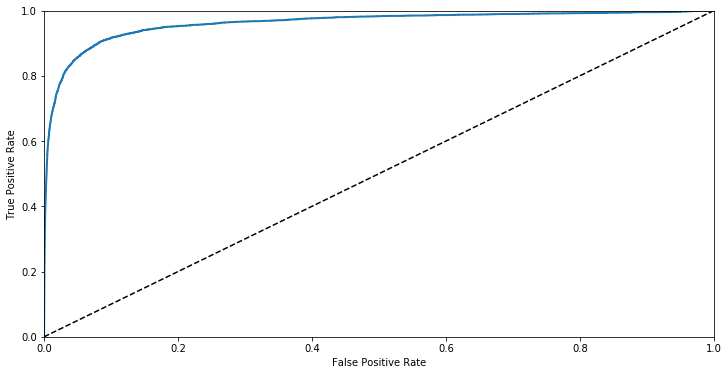

In [25]:
plot_roc_curve(fpr, tpr)

The dotted line represents a random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the *the area under the curve* (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [26]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.961692100217986

### Train a ```RandomForestClassifier``` and plot the PR and ROC curves

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, method="predict_proba")

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


To plot ROC curve you need scores, not probabilities. A simple solution is to use the positive class's probability as the score

In [28]:
y_scores_forest = y_probas_forest[:,1] # socre = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

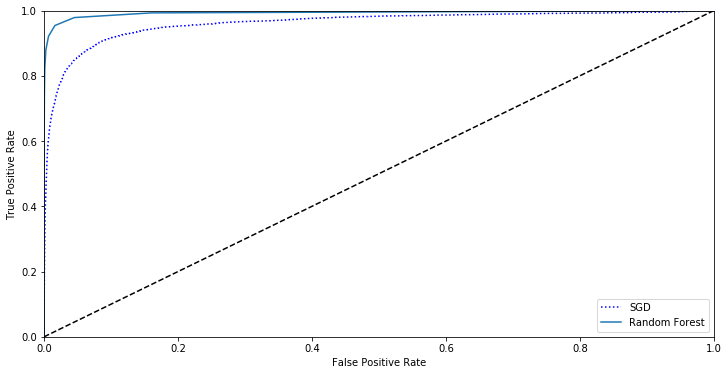

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0,1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

As you can see, the random forest classifier looks much better than SGD as it approaches more to the top-left corner. It is expected then, that the ROC AUC to be greater.

In [30]:
roc_auc_score(y_train_5, y_scores_forest)

0.992989878463262

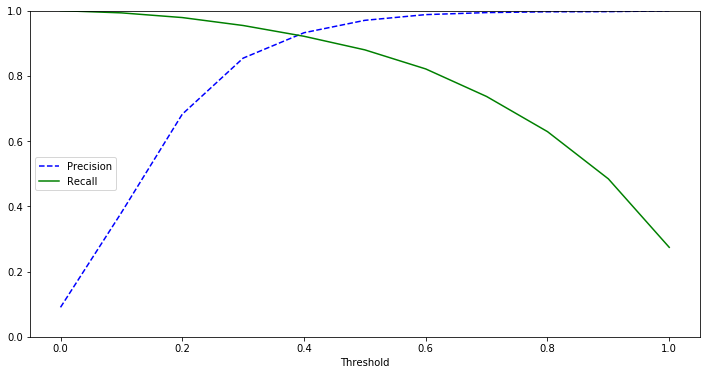

In [31]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_forest)

plot_recision_recall_vs_threshold(precisions, recalls, thresholds)

# Multinomial classification
Now let's treat this problem as actually is, we have 10 classes, not just 2, hence we should build a multinomial classifier instead of binary.

Some algorithms like *Random Forests* or *Naive Bayes* are capable of handling several classes directly. But others such as *SVM* or *Linear Classifiers* are strictly binary. Despite this, it is possible to use them like mupliple binary classifiers as workaround.

For MNIST case, we might have a binary classifier per class, like 1-detector, 2-detector, and so on. Then, you put them all to vote and pick the one with highest score. This is called *one-versus-all (OvA)* strategy.

Another strategy is *one-versus-one (OvO)* which is building binary classifiers for every pair e.g., 0-1, 0-2, 0-3, etc. The amount of classifiers to train depends on the amount of classes: $N \times(N-1)/2$. This means for MNIST we will need to train: $10\times(10-1)/2 = 45$. This might sound too much, but the good thing is that each classifier will only be need to be trained on the data part that corresponds to the pair of numbers. The winner is the one that wins most matches.

## OvA vs OvO
For large datasets, sometimes OvO is preferred if the chosen algorithm scales poorly. But generaly OvA is preferred.

Scikit's automatically detects when you are trying to use a binary classifier for multiclass classification, it automatically runs OvA (except for SVM which uses OvO).

In [32]:
# Notice we don't change anything, only pass the original multinomial y_train
sgd_clf.fit(X_train, y_train)

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
print("Actual: ", y_train[0])
print("Predicted: ", sgd_clf.predict([X_train[0]]))

Actual:  6
Predicted:  ['6']


In [34]:
some_digits_score = sgd_clf.decision_function([X_train[0]])
some_digits_score

array([[ -79077.00723128, -857721.32838692, -111907.8709303 ,
        -801807.40822724,   10851.1542503 , -178910.74617153,
         171390.9373029 , -408466.19642841, -634619.87304828,
        -485371.4706977 ]])

Notice now decision_function does not output a single score but an array of scores, this is to reflect every class available. The highest value is indeed the output class.

In [35]:
np.argmax(some_digits_score)

6

In [36]:
sgd_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [37]:
sgd_clf.classes_[1]

'1'

If we want to force Scikit's OvO, we can use the ```OveVsOneClassifier``` or ```OneVsRestClassifier``` as wrapper of the model.

In [38]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been add

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been add

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been add

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [39]:
ovo_clf.predict([X_train[0]])

array(['6'], dtype=object)

In [40]:
ovo_clf.estimators_

(SGDClassifier(alpha=0.0001, average=False, class_weight=None,
        early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
        l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
        n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
        power_t=0.5, random_state=42, shuffle=True, tol=None,
        validation_fraction=0.1, verbose=0, warm_start=False),
 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
        early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
        l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
        n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
        power_t=0.5, random_state=42, shuffle=True, tol=None,
        validation_fraction=0.1, verbose=0, warm_start=False),
 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
        early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
        l1_ratio=0.15, learning_rate='optimal', loss

Training a random forest is pretty straight forward and does not need any explicit OvO or OvA as this algorithm already supports multiclass.

In [41]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
forest_clf.predict([X_train[0]])

array(['6'], dtype=object)

In [43]:
forest_clf.predict_proba([X_train[0]])

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score

def model_scoring(y, y_pred, avg="micro", label=None):
    if label:
        print("Scores for model: ", label)
    ps = precision_score(y, y_pred, average=avg)
    rs = recall_score(y, y_pred, average=avg)
    f1s = f1_score(y, y_pred, average=avg)
    print("Precision: {}, Recall: {}, f1 score: {}".format(ps, rs, f1s))

In [45]:
sgd = sgd_clf.predict(X_train)
ovo = ovo_clf.predict(X_train)
forest = forest_clf.predict(X_train)

In [46]:
model_scoring(y_train, sgd, avg='macro', label="SGD")
model_scoring(y_train, ovo, avg='macro', label="OVO-SGD")
model_scoring(y_train, forest, avg='macro', label="Random Forest")

Scores for model:  SGD
Precision: 0.8818765375432829, Recall: 0.8754578060163523, f1 score: 0.8743037567153354
Scores for model:  OVO-SGD
Precision: 0.9286663445538013, Recall: 0.9283716348247598, f1 score: 0.9281046346179009
Scores for model:  Random Forest
Precision: 0.9992056642551932, Recall: 0.9991885883601711, f1 score: 0.99919690201754


We can measure the accuracy with cross validation technique

In [47]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been add

array([0.86952609, 0.87284364, 0.86242936])

This is not a bad score, however, scaling the input, improves the score even more

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

With ```StandardScaler``` what we are doing is transforming the original pixel values into a unit variance form. They represent the same information but the distribution changes a bit. So they try to move the data as if they distribute in a normal or gaussian form. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

Look at these plots for the first element.

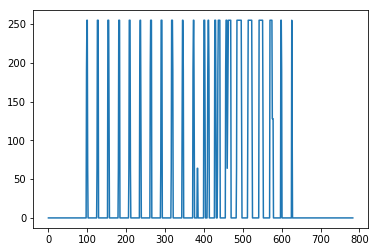

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(X_train[0])
plt.show()

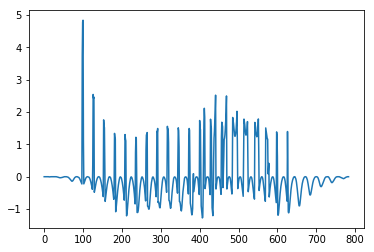

In [50]:
%matplotlib inline
plt.plot(X_train_scaled[0])
plt.show()

You can notice that the second one distribute more normally.

In [51]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been add

array([0.91036793, 0.90964548, 0.90713607])

With just this, we "improved" the metrics to 90%.

Now, we can continuing exploring options to improve the score by exploring the type of errors the model is doing. One option could be to explore the confusion matrix.

In [52]:
y_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_pred)
conf_mx

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been add

array([[5722,    3,   21,   10,   11,   52,   48,   10,   41,    5],
       [   2, 6479,   42,   26,    6,   37,    8,   11,  117,   14],
       [  50,   40, 5307,  116,   80,   32,   93,   62,  160,   18],
       [  51,   38,  136, 5342,    3,  229,   36,   54,  134,  108],
       [  24,   28,   37,    7, 5360,    7,   49,   36,   88,  206],
       [  76,   43,   32,  179,   75, 4617,  108,   28,  165,   98],
       [  32,   23,   45,    2,   48,   94, 5627,    4,   43,    0],
       [  23,   23,   66,   26,   57,   11,    4, 5804,   15,  236],
       [  61,  151,   69,  159,   14,  164,   57,   24, 5007,  145],
       [  46,   33,   25,   85,  177,   33,    2,  195,   75, 5278]])

And a prettier print

In [53]:
import seaborn as sn
import pandas as pd

def plot_confusion_matrix(model, inputs, labels, cv=3):    
    Y_pred = cross_val_predict(model, inputs, labels, cv=cv)

    cm = confusion_matrix(labels, y_pred)

    df_cm = pd.DataFrame(cm, range(10), range(10))
    plt.figure(figsize = (14, 8))
    sn.set(font_scale = 1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={'size': 12})
    plt.show()

/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ferro/anaconda3/envs/Deeplearning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been add

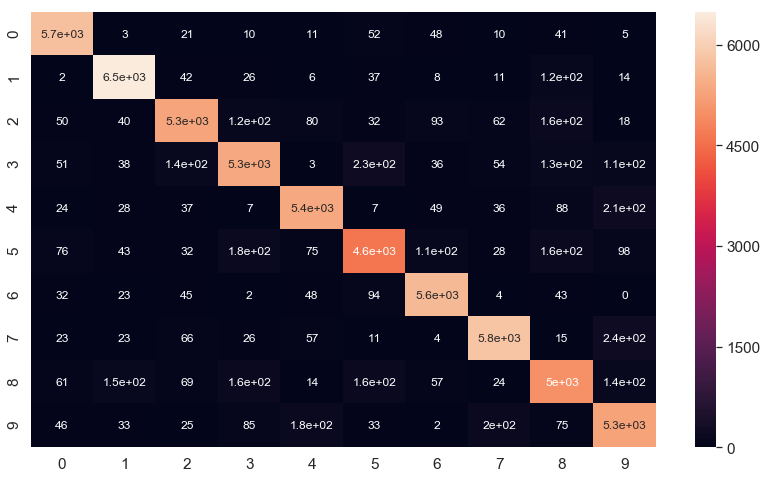

In [54]:
plot_confusion_matrix(sgd_clf, X_train_scaled, y_train)

Or using the ```matshow``` function of matplotlib

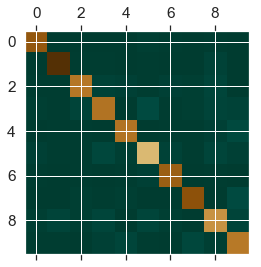

In [55]:
%matplotlib inline
plt.matshow(conf_mx, cmap=plt.cm.BrBG_r, shape=(10, 10))

It seems like number 5 is a special case, it looks slightly darker or lighter, depending on the matrix you are looking. This might be because there are fewer images of 5 in the dataset, or something else. So let's focus on these errors.

First, devide each value in the confusion matrix by the number of images in the corresponding class, this way we can compare error rates instead of absolute number of errors (which would make abundant classes look unfairly bad):

In [56]:
# simply sums all the values per row, it's like squeezing all the columns, aggregating by summation per row
## axis=1 means it will sum by the first axis instead of aggregating all the values in te matrix
### axis 0 is the X axis, the horizontal line, so it's like squeezing all the rows into the columns
### axis 1 is the Y axis, the vertical line, so it's what we want.
## keepdims (if set to true) is to keep the dimensionality of the original matrix
### When we sum, we get a 1D array, of shape (10,), if we pass true, we get a 2D array of shape (1, 10)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Now, let's fill the diagonal with zeros to keep only the errors.

**Note:** This will endup with ratios where the closer to 0 (darker) the more accurate, while, the closer to 1 (brighter) the less accurate or more mistakes are made for a specific category.

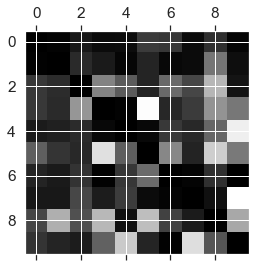

In [57]:
%matplotlib inline
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

This image is telling us that for 8 and 9, there are missclasified images as these columns and rows are brither than the others, so when the model is dealing with one of these digits, it seems is confusing it with another.

Looking at this plot can give you some ideas on where to improve, for instance you have already detected that 8 and 9 can be improved by engineering other features for them, obtaining more samples of these, designing an algorithm that be able to detect closed loops like in 8, 6 or 9, and even preprocess the images to make these loops stand out so when feed to the algorithm these are learnt more easily and be able to improve accuracy.

Options for the last part:
* Scikit-Image
* Pillow
* OpenCV

Analyzing individual errors can help you identifying what is the algorithm doing, for instance, let's compare images for 3 and 5.

In [58]:
# extract samples of 3 and 5
cl_a, cl_b = '3', '5'

# real A and predicted A
X_aa = X_train[(y_train == cl_a) & (y_pred == cl_a)]
# real A but predicted B
X_ab = X_train[(y_train == cl_a) & (y_pred == cl_b)]
# real B but predicted A
X_ba = X_train[(y_train == cl_b) & (y_pred == cl_a)]
# real B and predicted B
X_bb = X_train[(y_train == cl_b) & (y_pred == cl_b)]

In [59]:
import matplotlib

# Copy paste from the original
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

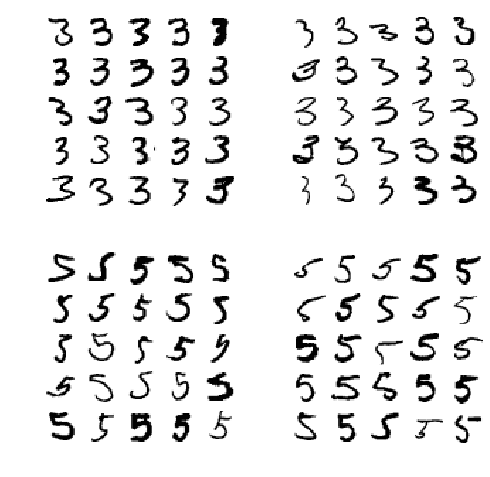

In [60]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Notice the first column shows images classified as 3, there are a bunch of 5s wrongly classified as 5, the second column is the opposite case. we have several 5 wrongly classified as 3.

Confusing 3 with 5 seems easy even for humans, let's face that some of these images are confusing. In this case, we might want to further preprocess to get rid of possible mistakes the model is doing.

# Multilable classification
So far we have been assigning a single class to each instance, but we might have scenarios where we might need to identify several classes in the same instance, like detecting in a picture if there are dogs, cats, and people, in this case, the output would be an array of 3 elements, 1 for each class and 1 if we detected such object and 0 if not. These kind of cases are called *multilable classification*.

Before image recognition, let's try to apply this concept to our current case for illustration purposes:

In [61]:
from sklearn.neighbors import KNeighborsClassifier

# The original y_train contains strings for all values,
# we must convert it to a numeric type first
f_y_train = y_train.astype('float64')
y_train_large = (f_y_train >= 7)
y_train_odd = (f_y_train % 2 == 1)
# Remember, this produces a matrix with each row as the pair of the first axis of each given array
y_multilabel = np.c_[y_train_large, y_train_odd]

In [62]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

```KNeighborsClassifier``` supports multilable classification, if we predict against the first digit, i.e., '0' we get the two labels, the first telling is not a large number (False) and the second telling is and odd number (True).

In [63]:
knn_clf.predict([X_train[0]])

array([[False, False]])

To evaluate this specific case, we could take the f1 score for each individual label, then average it to get the full score.
#### Warning:
The code below seems to take way to long, must be reviewed.

In [64]:
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
#f1_score(y_multilabel, y_train_knn_pred)

The above assumes all the lables have the same weight, but in some cases have unbalanced classes, in which we might want to weight higher for the one which has more samples. This can be done easily by passing the parameter ```average="weighted"``` to the above code.

# Multioutput classification
This is a generalization of multilable classification. It is basically stating that each output can have multiple lable and each label can have multiple outputs.

## Use case
Say we are going to take a noisy image of a number and we want to output a clear one, we would need to 'clean' and 'emphasize' the pixels that makes the number clearer. We are going to work on each pixel then, and each pixel can have different values (the intensity of the pixel).

First, lets generate noisy images.

In [65]:
# generate random numbers from 0 to 100 and place them in a matrix of shape 60000 (# of samples), 784 (# of pixels)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
# generate noise once more for the test set
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# In this case we expect to get the original images, i.e., the multioutput classification,
# hence the y would be the original X_train
y_train_mod = X_train
y_test_mod = X_test

Let's take a sneak peek on the input data.

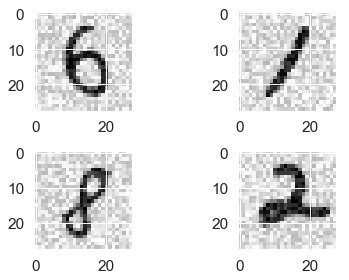

In [66]:
print_samples(X_train_mod, y_train_mod, (2, 2), print_labels=False)

The output will be, the same image but without noise, i.e., the original training set.

Let's train a KNN classifier.

In [67]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [68]:
clean_digit = knn_clf.predict(X_test_mod[:25])

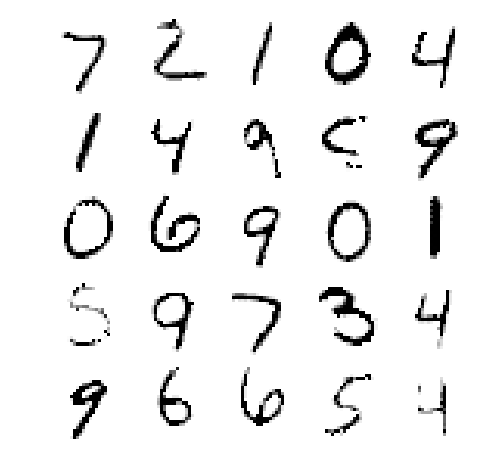

In [70]:
plt.figure(figsize=(8, 8))
plot_digits(clean_digit[:25], images_per_row=5)
plt.show()

Looks good, but some doesn't seem so well.

# Excercises

## 1. Increase accuracy to 97% using ```KNeighborsClassifier```

In [79]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_neighbors": list(range(1, 5)),
    "weights": ["uniform", "distance"]
}

knn_clf = KNeighborsClassifier(n_jobs=4)
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring="accuracy", verbose=2)

In [80]:
%%time
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_neighbors=1, weights=uniform ..................................


KeyboardInterrupt: 

## 2. Data augmentation

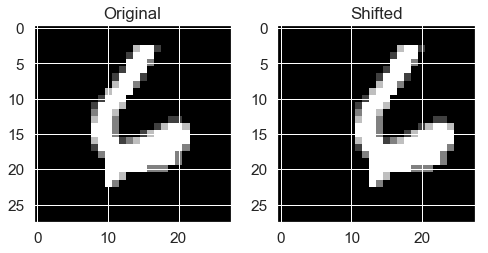

In [99]:
import numpy as np
from scipy.ndimage.interpolation import shift

xs = X_train[0].reshape(28, 28)
xsp = shift(xs, (0, 3))
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.imshow(xs, cmap=plt.cm.gray)
plt.title("Original")
plt.subplot(222)
plt.imshow(xsp, cmap=plt.cm.gray)
plt.title("Shifted")
plt.show()

In [100]:
import numpy as np
from scipy.ndimage.interpolation import shift

def shift_image(sample, pixels):
    """Will produce four images shifting the original 
    by the given number of pixels in all directions"""
    xs = sample.reshape(28, 28)
    up = shift(xs, (pixels, 0))
    down = shift(xs, (-pixels, 0))
    right = shift(xs, (0, pixels))
    left = shift(xs, (0, -pixels))
    return (up, down, left, right)